In [1]:
%matplotlib notebook
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt
import matplotlib.lines
import numpy as np

# Generate initial state

We use the code created by the ion trapping group to compute the equilibrium positions of ions in the Penning trap. First we import the `mode_analysis_code` module:

In [2]:
import mode_analysis_code

Then we create a `ModeAnalsysis` object. This object is central to all sorts of calculations. The parameter $N$ is the number of ions. The tuple `Vtrap` specifies the voltages on the trap electrodes. The parameter `Vwall` is the voltage on the rotating wall electrodes. And finally the parameter `frot` is the frequency of the rotating wall potential in ${\rm kHz}$. We will discuss the various voltages in more detail later on.

In [3]:
mode_analysis = mode_analysis_code.ModeAnalysis(N=127,
                                                Vtrap=(0.0, -1750.0, -2000.0),
                                                Vwall=5.0,
                                                frot=180.0)
mode_analysis_has_run = False

A complete mode analysis is executed via the run command. Note that this can be a rather lengthy computation (several minutes long) depending on the number of ions. Therefore we take precautions to not run the mode analysis a second time after it has already run. If you'd like to run the mode analysis a second time you need to set the variable `mode_analysis_has_run` to True.

In [4]:
if not mode_analysis_has_run:
    mode_analysis.run()
    mode_analysis_has_run = True

## Equilibrium positions of ions

The `ModeAnalysis.run()` call finds the equilibrium positions of the ions in the trap among other things. We can create a top view of the ion crystal by plotting the $x$ and $y$ coordinates of the ions:

<IPython.core.display.Javascript object>


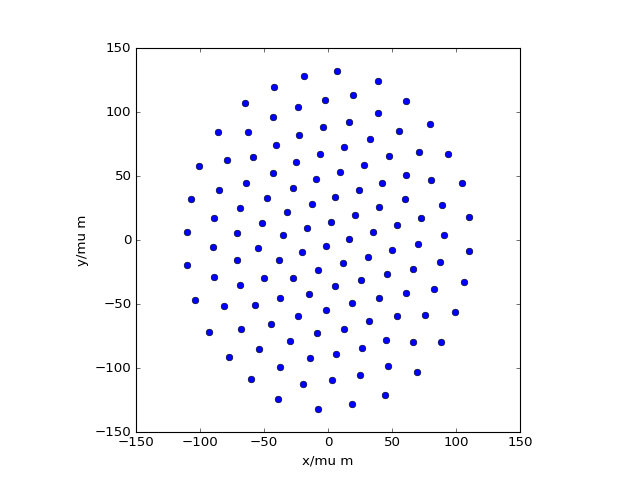

In [5]:
plt.figure()
plt.plot(1.0e6 * mode_analysis.uE[:mode_analysis.Nion], 1.0e6 * mode_analysis.uE[mode_analysis.Nion:], 'o');
plt.xlabel('x/mu m')
plt.ylabel('y/mu m')
rmax = 150.0
for l in [plt.xlim, plt.ylim]:
    l([-rmax, rmax])
plt.gca().set_aspect(1)

## Axial energy eigenvalues

The `ModeAnalyis` class also computes the axial eigenfrequencies of the ion crystal. There is a built-in method to visualize the eigenfrequencies:

<IPython.core.display.Javascript object>


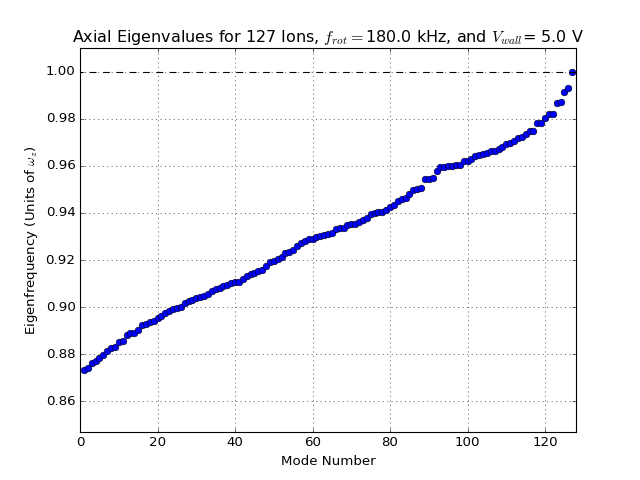

In [6]:
mode_analysis.show_axial_Evals();

# Units

Most calcualtions are done in a dimensionless system of units. Conversion to dimensionless and experimental form are done with the following two methods:

```
    def dimensionless(self):
        """Calculate characteristic quantities and convert to a dimensionless
        system
        """
        # characteristic length
        self.l0 = ((self.k_e * self.q ** 2) / (.5 * self.m_Be * self.wz ** 2)) ** (1 / 3)
        self.t0 = 1 / self.wz  # characteristic time
        self.v0 = self.l0 / self.t0  # characteristic velocity
        self.E0 = 0.5*self.m_Be*(self.wz**2)*self.l0**2 # characteristic energy
        self.wr = self.wrot / self.wz  # dimensionless rotation
        self.wc = self.wcyc / self.wz  # dimensionless cyclotron
        self.md = self.m / self.m_Be  # dimensionless mass

    def expUnits(self):
        """Convert dimensionless outputs to experimental units"""
        self.u0E = self.l0 * self.u0  # Seed lattice
        self.uE = self.l0 * self.u  # Equilibrium positions
        self.axialEvalsE = self.wz * self.axialEvals
        self.planarEvalsE = self.wz * self.planarEvals
        # eigenvectors are dimensionless anyway
```

Apparently the characteristic length is
$
l_0 = \left(\frac{q^2}{4\pi\epsilon_0}/(m \omega_z^2/2)\right)^{1/3}
$
Not quite sure what the meaning of this length scale is.


## Trap potential

The `ModeAnalysis.__init__()` method takes a parameter `Vtrap` that specifies the electrostatic potentials as far as I can tell. A comment in the source code suggests that the three components of this vector are the voltages on the end, middle, and center trap electrodes. Presumably these are in Volts. Inside `__init__()` we then calculate 0th, first, second, and fourth order moments of the trap potential at the center of the trap from the voltages. These are compute using a 4x3 matrix that is explained in "Teale's final paper". The result is stored in `self.Coeff`. The axial trap frequency is computed from this as follows:
$$
\omega_z=\sqrt{2 q {\tt self.Coeff[2]} / m}
$$
So this suggests that `self.Coeff[2]` corresponds to what I've been calling $k_z$:
$$
k_z = 2 Coeff[2]
$$

A "wall potential" of $V_{\rm wall}=5$ is translated into a coefficient ${\tt self.Cw2} = q V_{\rm wall} 1612$. Apparently this is not used anymore. Instead, we use the parameter ${\tt self.Cw} = 1612 V_{\rm wall} / V_0$ where $V_0 = 1/2 m \omega_z^2 / q$ which really reduces to ${\tt self.Coeff[2]}$. I think this make `self.Cw` equivalent with the parameter $\delta$ I've been using up to perhaps a factor of 2 which I need to check on. The stronger axis of the trap is along $x$, the weaker axis is along $y$.

Apparently we are using a trap rotation frequency of $180 {\rm kHz}$ by default.

The default axial magnetic field is $B_z=4.4588T$.

# Simulations of ion dynamics

In this section we take the ion crystal's generated above and stick them into a dynamical simulation of the ion motion. This calculation will be carried out in the laboratory frame (as opposed to the co-rotating frame).

In [7]:
import coldatoms

## Parameters for dynamic ion simulations

In order to run simulations of the ion dynamics we need all kinds of parameters. Most of these are trap parameters. Some of the more important ones are as follows:

In [8]:
print(mode_analysis.Cw)
print(mode_analysis.wrot)
print(mode_analysis.Coeff)
print(mode_analysis.wz)
print(mode_analysis.m_Be)
print(mode_analysis.q)
print(mode_analysis.B)
print(2.0 * np.pi / mode_analysis.wcyc)

0.00168764886016
1130973.3552923256
[ -1.71987500e+03  -1.25000000e+00   4.77587500e+06   1.89000000e+08]
10112373.2322
1.496535906374e-26
1.602176565e-19
4.4588
1.3162507819470977e-07


 ## Building the initial state of the ensemble
 
First we need to construct the initial state of the ions. To find the initial state we take the positions of the ions and translate the velocities from the co-rotating frame to the lab frame.

In [9]:
def create_ensemble(uE, omega_z, mass, charge):
    num_ions = int(uE.size / 2)
    x = uE[:num_ions]
    y = uE[num_ions:]
    r = np.sqrt(x**2 + y**2)
    r_hat = np.transpose(np.array([x / r, y / r]))
    phi_hat = np.transpose(np.array([-y / r, x / r]))
    v = np.zeros([num_ions, 2], dtype=np.float64)
    for i in range(num_ions):
        v[i, 0] = omega_z * r[i] * phi_hat[i, 0]
        v[i, 1] = omega_z * r[i] * phi_hat[i, 1]
    
    ensemble = coldatoms.Ensemble(num_ions)
    for i in range(num_ions):
        ensemble.x[i, 0] = x[i]
        ensemble.x[i, 1] = y[i]
        ensemble.x[i, 2] = 0.0
        ensemble.v[i, 0] = v[i, 0]
        ensemble.v[i, 1] = v[i, 1]
        ensemble.v[i, 2] = 0.0
    
    ensemble.ensemble_properties['mass'] = mass
    ensemble.ensemble_properties['charge'] = charge
    
    return ensemble

## Forces

Next we need to add the various forces: the Coulomb force between the ions, the trap forces, and the laser cooling forces. The Lorentz force due to the axial magnetic field in the Penning trap will be treated separately as it is taken care of geometrically by our integrator.

In [10]:
coulomb_force = coldatoms.CoulombForce()

In [11]:
class TrapPotential(object):

    def __init__(self, kz, delta, omega, phi_0):
        self.kz = kz
        self.kx = -(0.5 + delta) * kz
        self.ky = -(0.5 - delta) * kz
        self.phi_0 = phi_0
        self.phi = phi_0
        self.omega = omega

    def reset_phase(self):
        self.phi = self.phi_0
            
    def force(self, dt, ensemble, f):
        self.phi += self.omega * 0.5 * dt
        
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')

        cphi = np.cos(self.phi)
        sphi = np.sin(self.phi)
        kx = self.kx
        ky = self.ky
        
        x = ensemble.x[:, 0]
        y = ensemble.x[:, 1]
        z = ensemble.x[:, 2]
        
        f[:, 0] += dt * q * (
            (-kx * cphi * cphi - ky * sphi * sphi) * x + cphi * sphi * (ky - kx) * y)
        f[:, 1] += dt * q * (
            cphi * sphi * (ky - kx) * x + (-kx * sphi * sphi - ky * cphi * cphi) * y)
        f[:, 2] += -dt * q *self.kz * z

        self.phi += self.omega * 0.5 * dt

In [12]:
trap_potential = TrapPotential(2.0 * mode_analysis.Coeff[2], mode_analysis.Cw, mode_analysis.wrot, np.pi / 2.0)

In [13]:
def evolve_ensemble(dt, t_max, ensemble, Bz, forces):
    num_steps = int(t_max / dt)
    coldatoms.bend_kick(dt, Bz, ensemble, forces, num_steps=num_steps)
    coldatoms.bend_kick(t_max - num_steps * dt, Bz, ensemble, forces)

## Validate steady state

First we need to convince ourselves that the ground state calculation in the co-rotating frame is consistent with the dynamical simulations. To this end we evolve the ensemble state a time $\Delta t$ into the future and then we rotate the ions back an angle $\alpha=2\pi F_{\rm rot} \Delta t$. Unfortunately, as these figures show, the steady state found by the mode analysis code does not correspond to a steady state of the dynamical simulations.

In [14]:
def validate_steady_state(alpha):
    my_ensemble = create_ensemble(mode_analysis.uE,
                                  mode_analysis.wrot,
                                  mode_analysis.m_Be,
                                  mode_analysis.q)
    x_0 = np.copy(my_ensemble.x[:, 0])
    y_0 = np.copy(my_ensemble.x[:, 1])

    trap_potential.phi = np.pi / 2.0

    evolve_ensemble(1.0e-9, alpha / mode_analysis.wrot, my_ensemble, mode_analysis.B, [coulomb_force, trap_potential])

    plt.figure()
    plt.plot(1.0e3 * x_0, 1.0e3 * y_0, 'go', ms=4)
    plt.plot(1.0e3 * (np.cos(-alpha) * my_ensemble.x[:, 0] - np.sin(-alpha) * my_ensemble.x[:, 1]),
             1.0e3 * (np.sin(-alpha) * my_ensemble.x[:, 0] + np.cos(-alpha) * my_ensemble.x[:, 1]), 'ro', ms=2)
    plt.xlabel('x / mm')
    plt.ylabel('y / mm')
    x_max = 0.17e0
    y_max = x_max
    plt.xlim([-x_max, x_max])
    plt.ylim([-y_max, y_max])
    plt.axes().set_aspect('equal', 'datalim')
    plt.xlabel(r'$x/{\rm mm}$')
    plt.ylabel(r'$y/{\rm mm}$')
    
    return my_ensemble

<IPython.core.display.Javascript object>


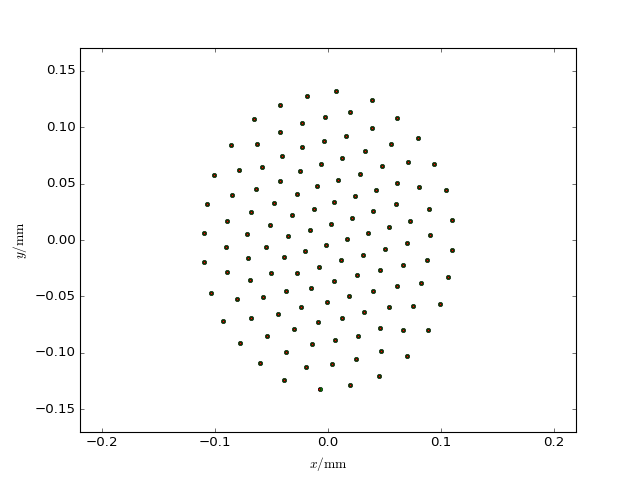

In [15]:
num_revolutions = 3.7
validate_steady_state(num_revolutions * 2.0 * np.pi);

To understand the issue a little bit better we consider the trajectory of an ion:

In [16]:
def compute_trajectory(dt, t_max, forces):
    my_ensemble = create_ensemble(mode_analysis.uE,
                                  mode_analysis.wrot,
                                  mode_analysis.m_Be,
                                  mode_analysis.q)
    positions = [np.copy(my_ensemble.x)]

    trap_potential.phi = np.pi / 2.0

    t = 0.0
    while t < t_max:
        coldatoms.bend_kick(dt, mode_analysis.B, my_ensemble, forces)
        positions.append(np.copy(my_ensemble.x))
        t += dt

    return np.array(positions)

In [17]:
t_max = 0.5 * 2.0 * np.pi / mode_analysis.wrot
print("t_max == ", t_max)
print("2 pi / w_cycl == ", 2.0 * np.pi / mode_analysis.wcyc)
dt = 0.05 * 2.0 * np.pi / mode_analysis.wcyc
print("dt == ", dt)

trajectories = compute_trajectory(dt, t_max, [coulomb_force, trap_potential])

t_max ==  2.7777777777777775e-06
2 pi / w_cycl ==  1.3162507819470977e-07
dt ==  6.581253909735489e-09


<IPython.core.display.Javascript object>


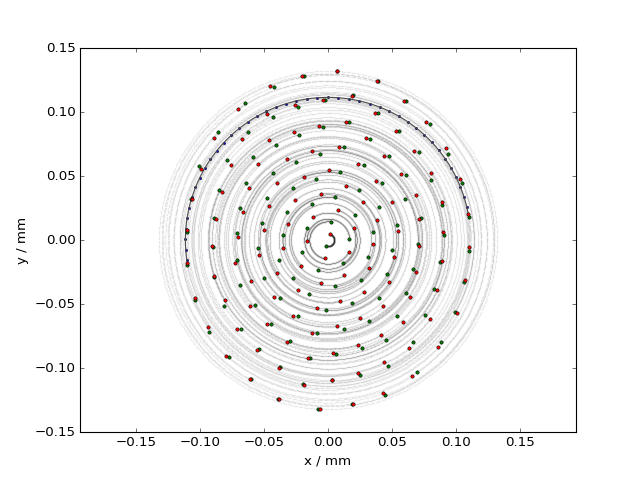

In [18]:
plt.figure()
ptcl = 100
line = matplotlib.lines.Line2D(1.0e3 * trajectories[:, ptcl, 0], 1.0e3 * trajectories[:, ptcl, 1], color='0.3')
plt.plot(1.0e3 * trajectories[:, :, 0], 1.0e3 * trajectories[:, :, 1],'o', color='0.5', alpha=0.05, ms=1)
plt.plot(1.0e3 * trajectories[::10, ptcl, 0], 1.0e3 * trajectories[::10, ptcl, 1],'bo', ms=2)
plt.gca().add_line(line)
plt.plot(1.0e3 * trajectories[0, :, 0], 1.0e3 * trajectories[0, :, 1],'go', ms=3)
plt.plot(1.0e3 * trajectories[-1, :, 0], 1.0e3 * trajectories[-1, :, 1],'ro', ms=3)
plt.xlabel('x / mm')
plt.ylabel('y / mm')
x_max = 0.15e0
y_max = x_max
plt.xlim([-x_max, x_max])
plt.ylim([-y_max, y_max])
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('trajectories.png', dpi=300)

# Single plane-two plane transition

Another benchmark for the dynamical simulations is the transition from a single plane crystal to multiple planes as the rotation frequency is increased.

# Evolution with damping

The ModeAnalysis code gives us the ability to compute a steady state to a good approximation. However, sometimes we will want to change a parameter of the system (such as the rotation frequency of the rotating wall potential) and then we will want to find the steady state of the ions in this slightly perturbed system. To find the new steady state we need to add damping to the system evolution.

We consider two specific instances of damping. The first one aims to make all ions circulate in the trap at the desired rotation frequency. The second damping is a simplified Doppler cooling force.

In [19]:
class AngularDamping(object):

    def __init__(self, omega, kappa_theta):
        self.omega = omega
        self.kappa_theta = kappa_theta
            
    def dampen(self, dt, ensemble):
        x = ensemble.x[:, 0]
        y = ensemble.x[:, 1]
        z = ensemble.x[:, 2]
        vx = ensemble.v[:, 0]
        vy = ensemble.v[:, 1]
        vz = ensemble.v[:, 2]
        
        expMinusKappaDt = np.exp(-self.kappa_theta * dt)
        
        for i in range(ensemble.num_ptcls):
            r = np.sqrt(x[i] * x[i] + y[i] * y[i])
            v = np.array([vx[i], vy[i]])
            v_hat = np.array([-y[i], x[i]]) / r
            v_par = v_hat.dot(v) * v_hat
            v_perp = v - v_par
            v_target = self.omega * r * v_hat
            
            v_updated = v_perp + v_target + (v_par - v_target) * expMinusKappaDt
            ensemble.v[i, 0] = v_updated[0]
            ensemble.v[i, 1] = v_updated[1]

The following damping mimics Doppler cooling with a constant cooling rate (and hence infinite capture range) and without the fluctuating recoil force.

In [20]:
class SimplisticOpticalMolasses(object):
    """Doppler cooling along x without recoil."""

    def __init__(self, kappa, sigma):
        """kappa is the damping rate and sigma is the 1/e diameter of the cooling beam."""
        self.kappa = kappa
        self.sigma = sigma
            
    def dampen(self, dt, ensemble):
        vx = ensemble.v[:, 0]
        y = ensemble.x[:, 1]

        damping_factor = np.exp(-self.kappa * dt)
        intensity = np.exp(-(y**2) / (self.sigma**2))
        
        ensemble.v[:, 0] = (1.0 - intensity) * vx + intensity * damping_factor * vx

We can augment our evolution algorithm rathe reasily by applying the dampings after each time step.

In [21]:
def evolve_ensemble_with_damping(dt, t_max, ensemble, Bz, forces, dampings):
    t = 0
    while t < t_max:
        coldatoms.bend_kick(dt, Bz, ensemble, forces, num_steps=1)
        for d in dampings:
            d.dampen(dt, ensemble)
        t += dt

Using this evolution we can define a function that creates an ensemble and evolves it to steady state:

In [22]:
def evolve_to_steady_state(dt=1.0e-9, t_max=1.0e-8, dampings=[],
                           omega=2.0 * np.pi * 180.0e3):
    my_ensemble = create_ensemble(mode_analysis.uE,
                                  omega,
                                  mode_analysis.m_Be,
                                  mode_analysis.q)

    x_0 = np.copy(my_ensemble.x)
    v_0 = np.copy(my_ensemble.v)
    
    trap_potential.phi = np.pi / 2.0
    trap_potential.omega = omega

    evolve_ensemble_with_damping(
        dt,
        t_max,
        my_ensemble,
        mode_analysis.B,
        [coulomb_force, trap_potential],
        dampings)
    
    return (my_ensemble, x_0, v_0)

First we'll try to verify that the crystal we got from the mode analysis is indeed a steady state. This will also allow us to determine how much we can push the cooling with inducing defects in the crystal. Note that in our cooling configuration the particles have almost zero velocity parallel to the cooling beams. So we wouldn't expect too strong of a cooling force.

In [23]:
def show_final_state(
    omega=1.0 * mode_analysis.wrot,
    t_max=1.0e-8,
    dt=1.0e-9,
    kappa=1.0e5,
    sigma=10.0e-6,
    side_view=False):
    
    my_ensemble, x0, v0 = evolve_to_steady_state(t_max=t_max,
                                                 dt=dt,
                                                 omega=omega,
                                                 dampings=[SimplisticOpticalMolasses(kappa, sigma)]);

    alpha = -omega * t_max
    sa = np.sin(alpha)
    ca = np.cos(alpha)
    plt.figure()
    plt.plot(x0[:, 0], x0[:, 1], 'go', ms=3)
    plt.plot(ca * my_ensemble.x[:, 0] - sa * my_ensemble.x[:, 1],
             sa * my_ensemble.x[:, 0] + ca * my_ensemble.x[:, 1], 'ro', ms=2)
    x_lim = 1.5e-4
    plt.xlim(-x_lim, x_lim)
    plt.ylim(-x_lim, x_lim)
    plt.axes().set_aspect('equal', 'datalim')
    
    if side_view==True:
        plt.figure()
        plt.plot(x0[:, 0], x0[:, 2], 'go', ms=3)
        plt.plot(my_ensemble.x[:, 0], my_ensemble.x[:, 2], 'ro', ms=2)
        x_lim = 1.5e-4
        plt.xlim(-x_lim, x_lim)
        plt.axes().set_aspect('equal', 'datalim')

Here's the ion configuration after 10 revolutions with a damping force of 1.0e6

<IPython.core.display.Javascript object>


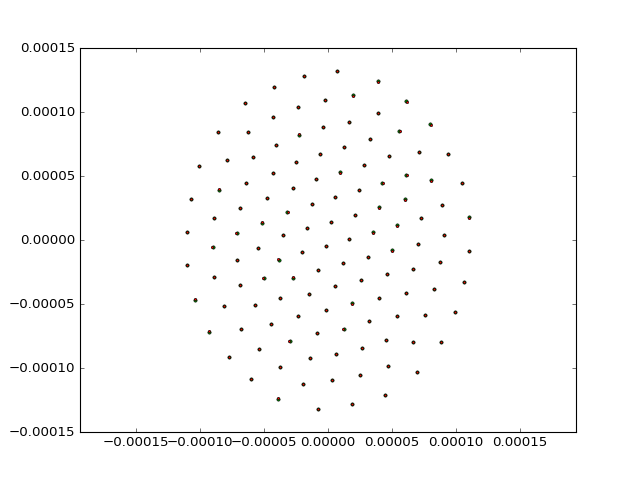

In [24]:
show_final_state(
    omega = 1.0 * mode_analysis.wrot,
    t_max = 1.0e1 * 2.0 * np.pi / mode_analysis.wrot,
    dt=5.0e-9,
    kappa = 1.0e5,
    sigma = 10.0e-6)

When we increase the diameter of the fictitious cooling beam we can see that the crystals stability suffers due to the torque imparted on the ions.

<IPython.core.display.Javascript object>


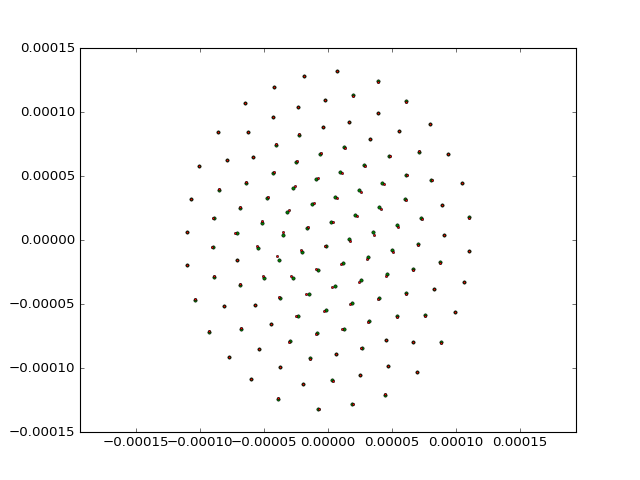

In [25]:
show_final_state(
    omega = 1.0 * mode_analysis.wrot,
    t_max = 1.0e1 * 2.0 * np.pi / mode_analysis.wrot,
    dt=5.0e-9,
    kappa = 1.0e5,
    sigma = 25.0e-6)

<IPython.core.display.Javascript object>


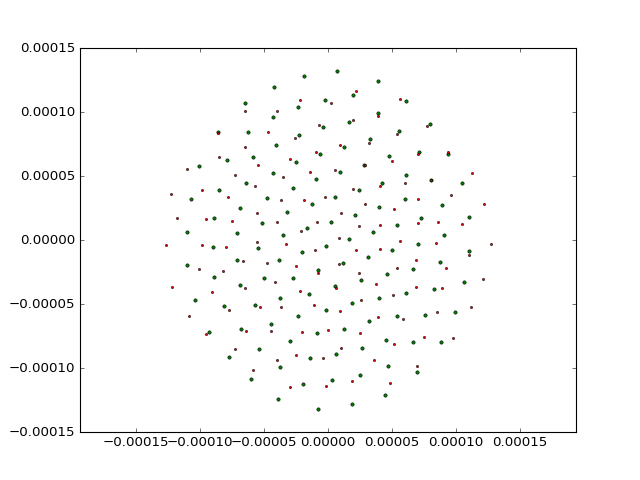

<IPython.core.display.Javascript object>


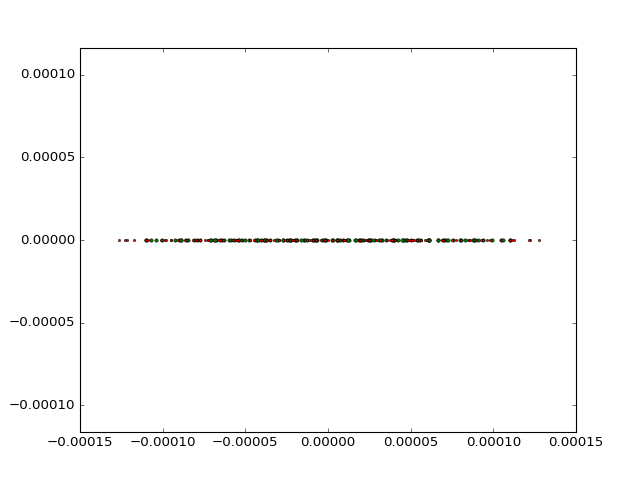

In [26]:
show_final_state(
    omega = 1.25 * mode_analysis.wrot,
    t_max = 1.0e2 * 2.0 * np.pi / mode_analysis.wrot,
    dt=5.0e-9,
    kappa = 1.0e5,
    sigma = 10.0e-6,
    side_view=True)

To gain some insight into the dynamics of the ions while they evolve to steady state we define two functions that let us compute radial distance from the center of the trap and the speed of the ions.

In [27]:
def radius(x):
    return np.sqrt(x[:, 0]**2 + x[:, 1]**2)

def speed(v):
    return np.sqrt(v[:, 0]**2 + v[:, 1]**2 + v[:, 2]**2)

def radial_velocity(x, v):
    num_ptcls = v.shape[0]
    velocity = np.zeros(num_ptcls)
    for i in range(num_ptcls):
        r_hat = np.copy(x[i, :2])
        r_hat /= np.linalg.norm(r_hat)
        velocity[i] = r_hat.dot(v[i, :2])
    return velocity

def angular_velocity(x, v):
    num_ptcls = v.shape[0]
    velocity = np.zeros(num_ptcls)
    for i in range(num_ptcls):
        r_hat = np.copy(x[i, :2])
        r_hat /= np.linalg.norm(r_hat)
        v_r = r_hat * (r_hat.dot(v[i, :2]))
        velocity[i] = np.linalg.norm(v[i, :2] - v_r)
    return velocity

1.058201058201058e-05


<IPython.core.display.Javascript object>


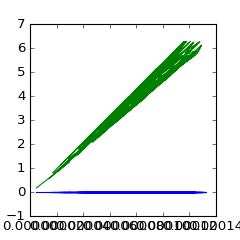

<IPython.core.display.Javascript object>


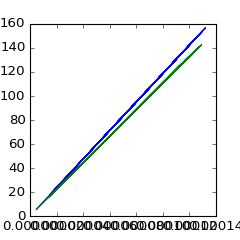

<IPython.core.display.Javascript object>


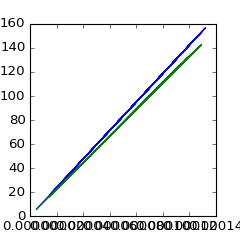

In [28]:
omega = 1.05 * mode_analysis.wrot
t_max = 2.0e0 * 2.0 * np.pi / omega
dt=1.0e-9
print(t_max)
kappa = 1.0e5
sigma = 10.0e-6
my_ensemble, x0, v0 = evolve_to_steady_state(t_max=t_max, dt=dt, omega=omega,
                                             dampings=[SimplisticOpticalMolasses(kappa, sigma)]);

plt.figure(figsize=(3,3))
plt.plot(radius(x0), radial_velocity(x0, v0))
plt.plot(radius(my_ensemble.x), radial_velocity(my_ensemble.x, my_ensemble.v))
plt.figure(figsize=(3,3))
plt.plot(radius(x0), angular_velocity(x0, v0))
plt.plot(radius(my_ensemble.x), angular_velocity(my_ensemble.x, my_ensemble.v))
plt.figure(figsize=(3,3))
plt.plot(radius(x0), speed(v0))
plt.plot(radius(my_ensemble.x), speed(my_ensemble.v))

In [29]:
def compute_speed_trajectory(dt=1.0e-9, t_max=1.0e-8, dampings=[],
                             omega=2.0 * np.pi * 180.0e3, num_dump=1):
    my_ensemble = create_ensemble(mode_analysis.uE,
                                  omega,
                                  mode_analysis.m_Be,
                                  mode_analysis.q)

    trap_potential.phi = np.pi / 2.0
    trap_potential.omega = omega
    
    avg_speeds = [np.mean(speed(my_ensemble.v))]
    avg_radial_speed = [np.mean(radial_velocity(my_ensemble.x, my_ensemble.v))]
    avg_angular_speed = [np.mean(angular_velocity(my_ensemble.x, my_ensemble.v))]

    t = 0
    i = 0
    forces = [coulomb_force, trap_potential]
    while t < t_max:
        coldatoms.bend_kick(dt, mode_analysis.B, my_ensemble, forces=forces)
        for d in dampings:
            d.dampen(dt, my_ensemble)
        t += dt
        if i % num_dump == 0:
            avg_speeds.append(np.mean(speed(my_ensemble.v)))
            avg_radial_speed.append(np.mean(radial_velocity(my_ensemble.x, my_ensemble.v)))
            avg_angular_speed.append(np.mean(angular_velocity(my_ensemble.x, my_ensemble.v)))
        i = i + 1
    
    return (np.array(avg_speeds), np.array(avg_radial_speed), np.array(avg_angular_speed))

0.005446623093681916


<IPython.core.display.Javascript object>


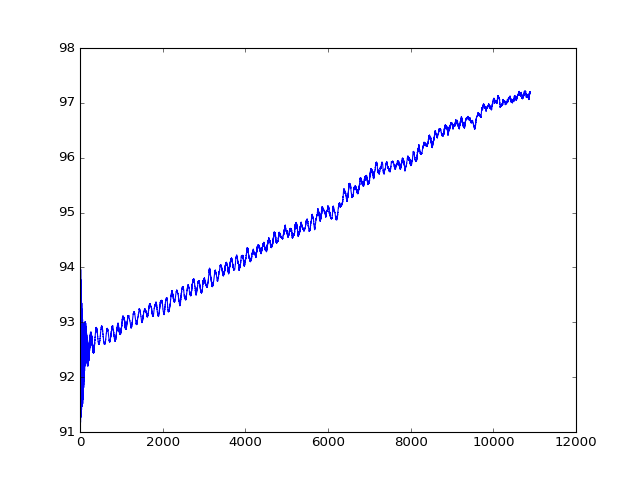

In [30]:
omega = 1.02 * mode_analysis.wrot
t_max = 1.0e3 * 2.0 * np.pi / omega
print(t_max)
kappa = 8.0e5
sigma = 1.0e-5
dt=5.0e-9
speeds, v_r, v_theta = compute_speed_trajectory(
    dt=dt, t_max=t_max, dampings=[SimplisticOpticalMolasses(kappa, sigma)],
    omega=omega, num_dump=100)
plt.figure()
plt.plot(v_theta)

In [31]:
np.mean(angular_velocity(x0, v0))

97.101425997912813

Here is an order of magnitude estimate of the Coulomb force acting on one of the ions near the fringe of the crystal. This looks reasonable.

In [32]:
f=np.zeros_like(my_ensemble.v)
coulomb_force.force(1.0e0, my_ensemble, f)
print(np.linalg.norm(f[-1]))

1.9146864939e-18


In [33]:
mode_analysis.m_Be

1.496535906374e-26

# Axial spectra

In order to study the axial spectra we need to excite the axial modes. To do this we use laser cooling beams. In addition to cooling, these beams also induce recoil heating.

In [34]:
class DopplerDetuning(object):
    def __init__(self, Delta0, k):
        self.Delta0 = Delta0
        self.k = np.copy(k)
        
    def detunings(self, x, v):
        return self.Delta0 - np.inner(self.k, v)

In [35]:
class GaussianBeam(object):
    """A laser beam with a Gaussian intensity profile."""
    
    def __init__(self, S0, x0, k, sigma):
        """Construct a Gaussian laser beam from position, direction, and width.
        
        S0 -- Peak intensity (in units of the saturation intensity).
        x0 -- A location on the center of the beam.
        k -- Propagation direction of the beam (need not be normalized).
        sigma -- 1/e width of the beam."""
        self.S0 = S0
        self.x0 = np.copy(x0)
        self.k_hat = k / np.linalg.norm(k)
        self.sigma = sigma
        
    def intensities(self, x):
        xp = x - self.x0
        xperp = xp - np.outer(xp.dot(self.k_hat[:, np.newaxis]), self.k_hat)
        return self.S0 * np.exp(-np.linalg.norm(xperp, axis=1)**2/self.sigma)

In [36]:
class UniformIntensity(object):
    """Uniform intensity profile."""
    
    def __init__(self, S0):
        self.S0 = S0
        
    def intensities(self, x):
        num_ptcls = x.shape[0]
        return np.full(num_ptcls, self.S0)

In [37]:
wavelength = 780.0e-9
k = 2.0 * np.pi / wavelength
gamma = 2.0 * np.pi * 6.1e6
hbar = 1.0e-34
sigma = 1.0e-3

cooling_beams = [
    coldatoms.RadiationPressure(gamma, hbar * kp,
                      UniformIntensity(S0=0.1),
                      DopplerDetuning(-0.5 * gamma, kp)) for kp in [
        np.array([0.0, 0.0, k]),
        np.array([0.0, 0.0, -k]),
    ]]

In [38]:
import time

delta_t ==  0.49117700000005016
num_steps ==  2001.0
delta_t / num_steps ==  0.000245465767116


<IPython.core.display.Javascript object>


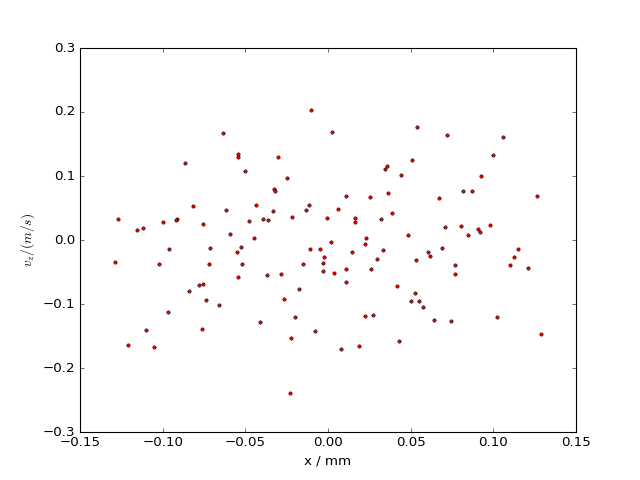

In [39]:
my_ensemble = create_ensemble(mode_analysis.uE,
                              mode_analysis.wrot,
                              mode_analysis.m_Be,
                              mode_analysis.q)

trap_potential.phi = np.pi / 2.0

t_max = 1.0e-5
dt = 5.0e-9
num_steps = np.ceil(t_max / dt)

t_start = time.clock()
evolve_ensemble(dt, t_max,
                my_ensemble, mode_analysis.B, [coulomb_force, trap_potential] + cooling_beams)
t_end = time.clock()
delta_t = t_end - t_start
print("delta_t == ", delta_t)
print("num_steps == ", num_steps)
print("delta_t / num_steps == ", delta_t / num_steps)

plt.figure()
plt.plot(1.0e3 * my_ensemble.x[:,0], my_ensemble.v[:,2], 'ro', ms=3)
plt.xlabel('x / mm')
plt.ylabel(r'$v_z / (m/s)$')

#x_max = 0.5e0
#y_max = x_max
#plt.xlim([-x_max, x_max])
#plt.ylim([-y_max, y_max])

In [40]:
positions = []
t_max = 2.0e-3
dt = 4.0e-9
num_steps = int(np.ceil(t_max / dt))
num_dump = 50

positions.append(np.copy(my_ensemble.x))
for i in range(num_steps // num_dump):
    coldatoms.bend_kick(dt, mode_analysis.B, my_ensemble,
                        [coulomb_force, trap_potential]+cooling_beams,
                        num_steps=num_dump)
    positions.append(np.copy(my_ensemble.x))
positions = np.array(positions)

<IPython.core.display.Javascript object>


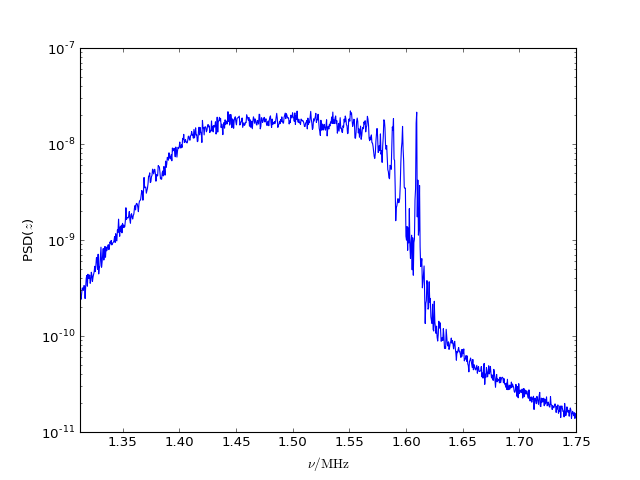

In [41]:
delta_t = num_dump * dt
nu_nyquist = 0.5 / delta_t
nu_axis = np.linspace(0.0, 2.0 * nu_nyquist, positions.shape[0])
plt.figure()
plt.semilogy(nu_axis / 1.0e6, np.sum(np.abs(np.fft.fft(positions[:,:,2],axis=0))**2, axis=1))
plt.xlim(0.525 * nu_nyquist / 1.0e6, 0.7 * nu_nyquist / 1.0e6)
plt.ylim(1.0e-11, 1.0e-7)
plt.xlabel(r'$\nu / \rm{MHz}$')
plt.ylabel(r'PSD($z$)');